In [22]:
import time,json,os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.ensemble import BaggingClassifier
from common import preprocess
import seaborn as sns
from sklearn.svm import SVC
import joblib
from warnings import filterwarnings
filterwarnings("ignore") 
np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x : '%.4f' % x)

# check distribution

In [3]:
df_s0 = pd.read_csv("/data/paper/base/s-0.csv",index_col=0)
df_s1 = pd.read_csv("/data/paper/base/s-1.csv",index_col=0)
df_s2 = pd.read_csv("/data/paper/base/s-2.csv",index_col=0)
df_s3 = pd.read_csv("/data/paper/base/s-3.csv",index_col=0)

In [4]:
print(df_s0['label'].value_counts())
print(df_s1['label'].value_counts())
print(df_s2['label'].value_counts())
print(df_s3['label'].value_counts())

benign      325155
abnormal    174845
Name: label, dtype: int64
abnormal    55874950
benign       9187041
Name: label, dtype: int64
abnormal    32533580
benign      32528411
Name: label, dtype: int64
benign      43378034
abnormal    21683957
Name: label, dtype: int64


In [2]:
df1 = pd.read_csv("/data/paper/sample/s-0-1-0.csv",index_col=0)
df2 = pd.read_csv("/data/paper/sample/s-1-1-0.csv",index_col=0)
df3 = pd.read_csv("/data/paper/sample/s-2-1-0.csv",index_col=0)
df4 = pd.read_csv("/data/paper/sample/s-3-1-0.csv",index_col=0)

In [3]:
print(df1['label'].value_counts())
print(df2['label'].value_counts())
print(df3['label'].value_counts())
print(df4['label'].value_counts())

benign      185997
abnormal     64003
Name: label, dtype: int64
abnormal    241187
benign        8813
Name: label, dtype: int64
benign      125329
abnormal    124671
Name: label, dtype: int64
benign      191870
abnormal     58130
Name: label, dtype: int64


In [3]:
def get_mahalanobis(x, i, j):
    xT = x.T  # 求转置
    D = np.cov(xT)  # 求协方差矩阵
    invD = np.linalg.inv(D)  # 协方差逆矩阵
    assert 0 <= i < x.shape[0], "点 1 索引超出样本范围。"
    assert -1 <= j < x.shape[0], "点 2 索引超出样本范围。"
    x_A = x[i]
    x_B = x.mean(axis=0) if j == -1 else x[j]
    tp = x_A - x_B
    return np.sqrt(np.dot(np.dot(tp, invD), tp.T))
    
# 初始化数据点集，或者从其它地方加载
x = np.array([[3, 4], [5, 6], [2, 2], [8, 4]])
# 求第0个点到均值之间的马氏距离（j为-1时代表均值）
print(get_mahalanobis(x, 0, -1))
# 求第0个点到第1个点之间的马氏距离
print(get_mahalanobis(x, 0, 1))
# 求第2个点到第3个点之间的马氏距离（索引从0开始算起）
print(get_mahalanobis(x, 2, 3))

0.6396021490668313
1.243163121016122
2.2763607319179844


# 统一计算

In [23]:
def show_heatmap(df):
    plt.style.use({'figure.figsize':(16, 6)})
    plt.ticklabel_format(style='plain',axis='both')
    cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
    sns.heatmap(df, cmap = cmap, linewidths = 0.05,annot=False, fmt="g",annot_kws={"fontsize":16})
    plt.xticks(rotation=60)
    plt.yticks(rotation=60)

In [28]:
class CJAnalyse:
    
    def __init__(self, model_name):
        self.df_similarity = pd.read_csv("/data/paper/analyse/similarity2.csv",index_col=0)
        self.df_model = pd.read_csv("/data/paper/analyse/%s.csv"%model_name,index_col=0)
        self.filter_useless_fields()
        
    def get_similar(self, d1, d2):
        mask = (self.df_similarity['D1'] == "%s.csv"%d1) & (self.df_similarity['D2'] == d2)
        ret = {}
        for D in self.df_similarity.keys():
            if D in ['D1','D2']:
                continue
            ret[D] = self.df_similarity[mask].iloc[0][D]
        return ret
    
    def filter_useless_fields(self):
        df_m = self.df_model.copy( deep = True )
        del df_m['confusion_matrix']
        del df_m['roc_curve']
        del df_m['mcc']
        del df_m['log_loss']
        del df_m['fbeta_score']
        self.df_model = df_m
        
    def Merge(self):
        all_data = []
        for item in json.loads(self.df_model.to_json(orient="records")):
            tmp = item
            tmp["train"] = item["train"]
            tmp["valid"] = item["valid"]
            similar = self.get_similar(item["train"], item['valid'])
            for s in similar:
                tmp[s] = similar[s]
            all_data.append(tmp)
        return pd.DataFrame(all_data)
    
    #pearsonr,spearmanr or kendalltau
    def Correlation(self,df_merged, kind = "pearsonr"):
        all_data = []
        for score in self.df_model.keys():
            if score in ['model', 'train', 'valid']:
                continue
            s1 = df_merged[score]
            metric_value = {}
            metric_value['score'] = score
            metric_list = self.df_similarity.keys()
            for metric in metric_list:
                if metric in ['D1','D2']:
                    continue
                s2 = df_merged[metric]
                if kind == 'pearsonr':
                    metric_value[metric] = scipy.stats.pearsonr(s1,s2)[0]
                if kind == 'spearmanr':
                    metric_value[metric] = scipy.stats.spearmanr(s1,s2)[0]
                if kind == 'kendalltau':
                    metric_value[metric] = scipy.stats.kendalltau(s1,s2)[0]
            all_data.append(metric_value)

        df_all = pd.DataFrame(all_data)
        df_all.set_index("score", inplace = True, drop = True)
        return df_all.reset_index()

In [29]:
test = CJAnalyse("rf")
df_all = test.Merge()

In [30]:
df_test  = df_all[df_all['train'] == 's-3-1-0']
df_corr = test.Correlation(df_test)
df_corr

,score,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
0,recall,0.6998,0.6998,-0.7288,-0.9846,0.4566,-0.9130,-0.6888,0.1754
1,accuracy,0.7722,0.7721,-0.7998,-0.5329,0.6476,-0.6902,-0.7879,0.3140
2,precision,0.2533,0.2533,-0.3196,-0.6891,0.3356,-0.5251,-0.3213,0.2175
3,auc,0.9081,0.9081,-0.9160,-0.6035,0.6458,-0.8043,-0.8855,0.2586
4,f1_score,0.5927,0.5928,-0.6351,-0.9560,0.4527,-0.8443,-0.6070,0.1970


<AxesSubplot:>

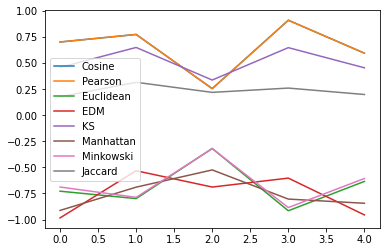

In [31]:
df_corr.plot()

In [ ]:
show_heatmap(pt)